# Contraceptive Method Choice

In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.metrics import log_loss, f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt


## Import dataset

**original dataset info**

   1. Wife's age                     (numerical)
   2. Wife's education               (categorical)      1=low, 2, 3, 4=high
   3. Husband's education            (categorical)      1=low, 2, 3, 4=high
   4. Number of children ever born   (numerical)
   5. Wife's religion                (binary)           0=Non-Islam, 1=Islam
   6. Wife's now working?            (binary)           0=Yes, 1=No
   7. Husband's occupation           (categorical)      1, 2, 3, 4
   8. Standard-of-living index       (categorical)      1=low, 2, 3, 4=high
   9. Media exposure                 (binary)           0=Good, 1=Not good
   10. Contraceptive method used     (class attribute)  1=No-use, 2=Long-term, 3=Short-term **<=**
   
**_Notes_**
- Column #10 is to be predicted.
- I'm going to change columns names and invert some of the values, as they don't correspond to common notation (e.g. #5,6,9)

In [2]:
path_to_data_set = os.path.join("UCI_datasets", "cmc", "cmc.data")

names = {
    "W_AGE"                  : 'int8',
    "W_EDU"                  : 'category',
    "H_EDU"                  : 'category',
    "NUM_CHILDREN"           : 'int8',
    "W_ISLAM"                : 'bool',
    "W_WORKING"              : 'bool',
    "H_JOB"                  : 'category',
    "SOL"                    : 'category',
    "BAD_MEDIA"              : 'bool',
    "CONT_USAGE"             : 'category'
}

table = pd.read_table(path_to_data_set, delimiter=",",  
                      header=None, index_col=False, 
                      names=names.keys(),
                      dtype=names,
                      engine='python'
                     )

In [3]:
table.head()

,W_AGE,W_EDU,H_EDU,NUM_CHILDREN,W_ISLAM,W_WORKING,H_JOB,SOL,BAD_MEDIA,CONT_USAGE
0,24,2,3,3,True,True,2,3,False,1
1,45,1,3,10,True,True,3,4,False,1
2,43,2,3,7,True,True,3,4,False,1
3,42,3,2,9,True,True,3,3,False,1
4,36,3,3,8,True,True,3,2,False,1


inverting values of columns

In [4]:
table["W_WORKING"] = table["W_WORKING"].apply(lambda x: not x)
# table["W_ISLAM"] = table["W_ISLAM"].apply(lambda x: not x)

### Data visualization

#### Unique values

In [5]:
for x in table.columns:
    print(x)
    print(table[x].unique())

W_AGE
[24 45 43 42 36 19 38 21 27 44 26 48 39 37 46 40 29 31 33 25 28 47 32 49
 34 20 22 30 23 35 41 17 18 16]
W_EDU
[2, 1, 3, 4]
Categories (4, object): [2, 1, 3, 4]
H_EDU
[3, 2, 4, 1]
Categories (4, object): [3, 2, 4, 1]
NUM_CHILDREN
[ 3 10  7  9  8  0  6  1  2  4  5 12 11 13 16]
W_ISLAM
[ True False]
W_WORKING
[False  True]
H_JOB
[2, 3, 1, 4]
Categories (4, object): [2, 3, 1, 4]
SOL
[3, 4, 2, 1]
Categories (4, object): [3, 4, 2, 1]
BAD_MEDIA
[False  True]
CONT_USAGE
[1, 2, 3]
Categories (3, object): [1, 2, 3]


#### Correlation matrix
It's only available for numeric values, but still worthy to have a look

In [6]:
corr_matrix = table.corr().round(2)

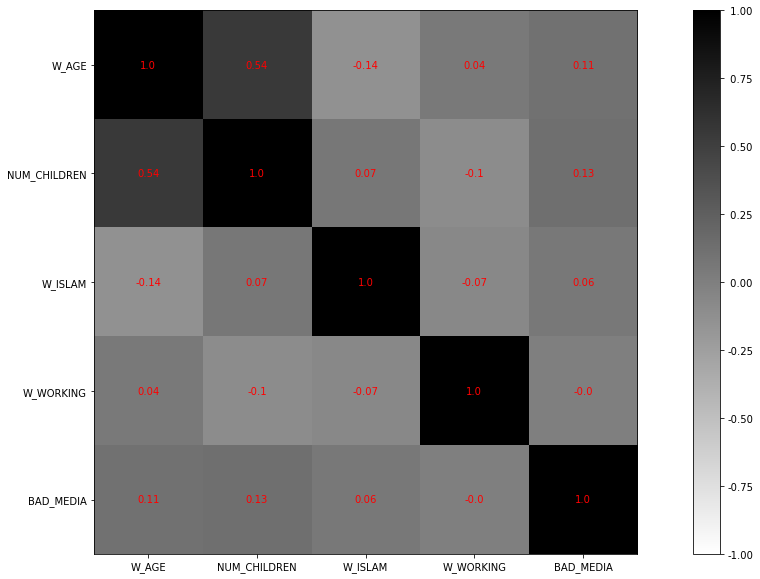

In [7]:
ig, ax = plt.subplots(figsize=(10,10))
ig.set_figwidth(20)

im = ax.imshow(corr_matrix, cmap='binary', interpolation='nearest')
im.set_clim(-1, 1)
ax.grid(False)
cols = ["",'W_AGE', 'NUM_CHILDREN', 'W_ISLAM', 'W_WORKING', 'BAD_MEDIA']

ax.set_xticklabels(cols)
ax.set_yticklabels(cols)

for i in range(5):
    for j in range(5):
        ax.text(j, i, corr_matrix.iloc[i, j], ha='center', va='center', color='r')
        

cbar = ax.figure.colorbar(im, ax=ax, format='% .2f')
plt.show()

Wife's Age histogram

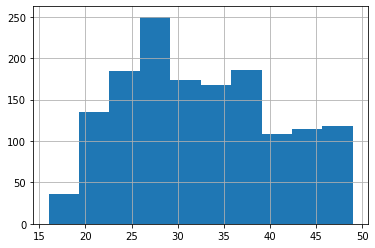

In [8]:
table['W_AGE'].hist()

 1. No-use
 2. Long-term
 3. Short-term 

Exploring number of values in each category
1. No-use
2. Long-term
3. Short-term 

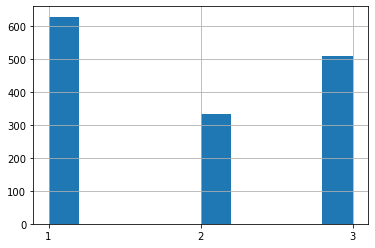

In [9]:
table['CONT_USAGE'].hist()

## Comparing models

`macro` is necessary for multilable classifiers

In [10]:
def metrics(clf, X, Y, t_x, t_y):
    pred = cross_val_predict(clf, X, Y, cv=3)
    y_pred = clf.predict(t_x)
    
    print('Accuracy on test set: {:.4%}'.format(accuracy_score(t_y, y_pred)))
    print('F1: {:.4%}'.format(f1_score(Y, pred, average="macro")))
    print('Precision: {:.4%}'.format(precision_score(Y, pred, average="macro")))
    print('Recall: {:.4%}'.format(recall_score(Y, pred, average="macro")))

### dataset split

In [11]:
X = table.drop(columns=['CONT_USAGE'], inplace=False)
y = table['CONT_USAGE'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

### Feature importance

In [12]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X, y)

RandomForestClassifier(random_state=42)

In [13]:
rnd_clf.feature_importances_

array([0.34904753, 0.08156451, 0.06512604, 0.23857516, 0.03334789,
       0.04501532, 0.08325647, 0.08858217, 0.01548491])

## Train model on original data

### A lot of classifiers with basic arguments

In [14]:
def choose_best_clf(X_train, X_test, y_train, y_test):
    classifiers = [
        KNeighborsClassifier(),
        SVC(kernel="rbf", C=0.025, probability=True, random_state=42),
        NuSVC(probability=True, random_state=42),
        DecisionTreeClassifier(random_state=42),
        RandomForestClassifier(random_state=42),
        AdaBoostClassifier(random_state=42),
        GradientBoostingClassifier(random_state=42),
        GaussianNB(),
        GaussianProcessClassifier(random_state=42),
        MultinomialNB(),
        LinearDiscriminantAnalysis(),
        QuadraticDiscriminantAnalysis(),
        ]
    
    # Logging for Visual Comparison
    log_cols=["Classifier", "Accuracy", "Log Loss"]
    log = pd.DataFrame(columns=log_cols)


    for clf in classifiers:
        name = clf.__class__.__name__
        try:
            clf.fit(X_train, y_train)
            print("="*30)
            print(name)
            print('****Results****')
            train_predictions = clf.predict(X_test)
            acc = accuracy_score(y_test, train_predictions)
            print("Accuracy: {:.4%}".format(acc))

            train_predictions = clf.predict_proba(X_test)
            ll = log_loss(y_test, train_predictions)
            print("Log Loss: {}".format(ll))

            log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
            log = log.append(log_entry)
        except ValueError:
            print("="*30, '\n')
            print(name, 'cannot be trained')

#     print("="*30)
    sns.set_color_codes("muted")
    sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

    plt.xlabel('Accuracy %')
    plt.title('Classifier Accuracy')
    plt.show()

    sns.set_color_codes("muted")
    sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

    plt.xlabel('Log Loss')
    plt.title('Classifier Log Loss')
    plt.show()

KNeighborsClassifier
****Results****
Accuracy: 59.4595%
Log Loss: 3.0270221128106
SVC
****Results****
Accuracy: 46.6216%
Log Loss: 0.9617033379723539
NuSVC
****Results****
Accuracy: 56.7568%
Log Loss: 1.0047965312954072
DecisionTreeClassifier
****Results****
Accuracy: 54.7297%
Log Loss: 14.963787651065159
RandomForestClassifier
****Results****
Accuracy: 54.0541%
Log Loss: 1.114292969318822
AdaBoostClassifier
****Results****
Accuracy: 58.7838%
Log Loss: 1.0729685053769045
GradientBoostingClassifier
****Results****
Accuracy: 52.7027%
Log Loss: 0.8606549630277129
GaussianNB
****Results****
Accuracy: 43.2432%
Log Loss: 1.2886419862600775
GaussianProcessClassifier
****Results****
Accuracy: 60.8108%
Log Loss: 1.0041892936311132
MultinomialNB
****Results****
Accuracy: 54.7297%
Log Loss: 0.9770386983941716
LinearDiscriminantAnalysis
****Results****
Accuracy: 52.7027%
Log Loss: 0.941200789194053
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 47.2973%
Log Loss: 1.1196182999782702


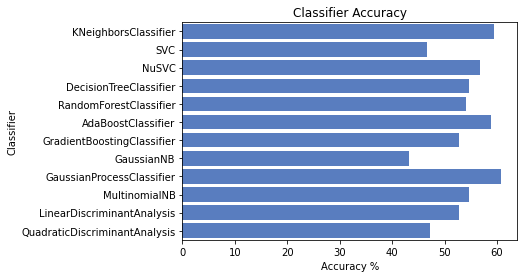

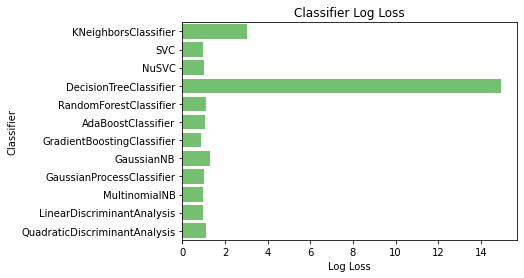

In [15]:
choose_best_clf(X_train, X_test, y_train, y_test)

### Dimensionality reduction on original data

In [16]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95)

In [17]:
d

1

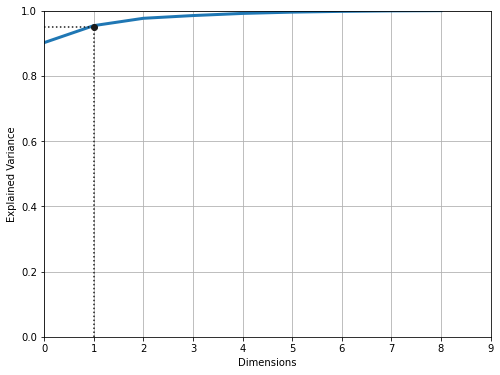

In [18]:
plt.figure(figsize=(8,6))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 9, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")

plt.plot(d, 0.95, "ko")
plt.grid(True)
plt.show()

In [19]:
pca = PCA(n_components=d)
pca.fit(X)
X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

# X_recovered = pca.inverse_transform(X_train_reduced_5)

In [20]:
X_train_reduced

array([[-13.89285591],
       [ 11.44166845],
       [ 11.14177016],
       ...,
       [ -3.57947689],
       [  4.69884653],
       [ -1.73375754]])

KNeighborsClassifier
****Results****
Accuracy: 47.9730%
Log Loss: 4.723417219226688
SVC
****Results****
Accuracy: 43.2432%
Log Loss: 1.0492434686924768
NuSVC
****Results****
Accuracy: 35.8108%
Log Loss: 1.0766413711848042
DecisionTreeClassifier
****Results****
Accuracy: 44.5946%
Log Loss: 18.240336055726438
RandomForestClassifier
****Results****
Accuracy: 45.2703%
Log Loss: 4.570502349559374
AdaBoostClassifier
****Results****
Accuracy: 43.9189%
Log Loss: 1.0927999959745711
GradientBoostingClassifier
****Results****
Accuracy: 48.6486%
Log Loss: 1.0120940112962116
GaussianNB
****Results****
Accuracy: 36.4865%
Log Loss: 1.0356177932842383
GaussianProcessClassifier
****Results****
Accuracy: 40.5405%
Log Loss: 1.0336754116075622

MultinomialNB cannot be trained
LinearDiscriminantAnalysis
****Results****
Accuracy: 42.5676%
Log Loss: 1.0517297628733306
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 36.4865%
Log Loss: 1.0356952247651983


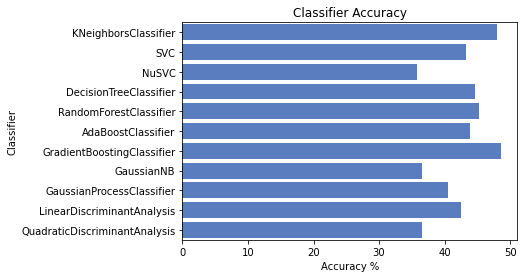

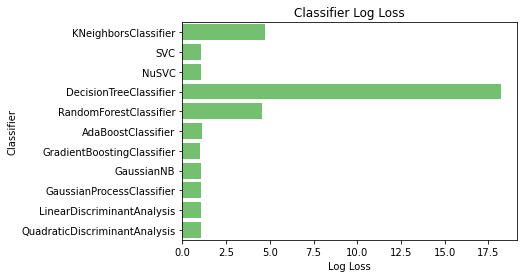

In [21]:
choose_best_clf(X_train_reduced, X_test_reduced, y_train, y_test)

## Bucketing(binning) values

To produce better results in training I'll bucket continuous variable in to discrete chunks.

Let's first explore histogram, to have a rough understanding of how many records we have in each age category

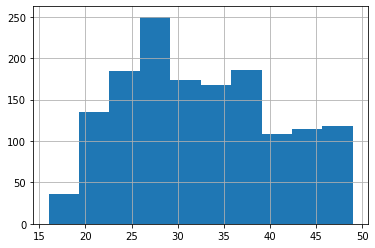

In [22]:
table['W_AGE'].hist()

Lets bucket in 4 different ranges, to make it more balanced the following ranges are chosen (pretty close to percentiles):

`[0, 25], (25, 32], (32, 40], (40, 50]`

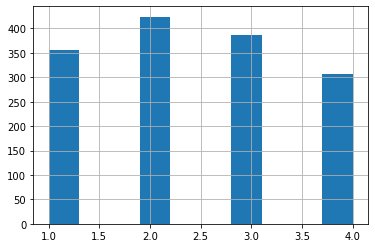

In [23]:
bins = [0, 25, 32, 40, 50]
labels = [1,2,3,4]

table['W_AGE_binned'] = pd.cut(table['W_AGE'], bins=bins, labels=labels)
# table = table.astype({'W_AGE_binned' : 'category'})
table['W_AGE_binned'].hist()
table.drop(columns=['W_AGE'], inplace=True)

Now is the time to bucket another discrete valued column. Let's look at number of unique values

In [24]:
table['NUM_CHILDREN'].value_counts()

2     276
1     276
3     259
4     197
5     135
0      97
6      92
7      49
8      47
9      16
11     11
10     11
12      4
13      2
16      1
Name: NUM_CHILDREN, dtype: int64

Due to bucketing limitations, I'll change all 0s to -1s, so .cut() can still be used

In [25]:
table["NUM_CHILDREN"] = table["NUM_CHILDREN"].apply(lambda x: -1 if x == 0 else x)

The here I'm going to bucket values according to the real world perspective

`[0], [1], [2], [3], [4, 5], [5+]`

So we can distinguish families without kids from families with kids, and small families from bigger families. This approach might be usefull for a more extensive research.

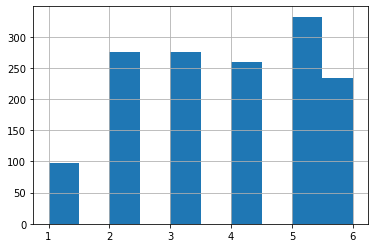

In [26]:
bins = [-2, 0, 1,2, 3, 5, 20]
labels = [1,2,3,4, 5, 6]


table['NUM_CHILDREN_binned'] = pd.cut(table['NUM_CHILDREN'], bins=bins, labels=labels)
# table = table.astype({'W_AGE_binned' : 'category'})
table['NUM_CHILDREN_binned'].hist()
table.drop(columns=['NUM_CHILDREN'], inplace=True)

In [27]:
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   W_EDU                1473 non-null   category
 1   H_EDU                1473 non-null   category
 2   W_ISLAM              1473 non-null   bool    
 3   W_WORKING            1473 non-null   bool    
 4   H_JOB                1473 non-null   category
 5   SOL                  1473 non-null   category
 6   BAD_MEDIA            1473 non-null   bool    
 7   CONT_USAGE           1473 non-null   category
 8   W_AGE_binned         1473 non-null   category
 9   NUM_CHILDREN_binned  1473 non-null   category
dtypes: bool(3), category(7)
memory usage: 15.7 KB


## Training models on dataset with binned data

In [28]:
X = table.drop(columns=['CONT_USAGE'], inplace=False)
y = table['CONT_USAGE'].copy()

Xb_train, Xb_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

KNeighborsClassifier
****Results****
Accuracy: 57.4324%
Log Loss: 3.4785248205812884
SVC
****Results****
Accuracy: 45.9459%
Log Loss: 0.9146969352111525
NuSVC
****Results****
Accuracy: 57.4324%
Log Loss: 0.916203461075256
DecisionTreeClassifier
****Results****
Accuracy: 50.6757%
Log Loss: 13.2588695687643
RandomForestClassifier
****Results****
Accuracy: 55.4054%
Log Loss: 1.4121079070630507
AdaBoostClassifier
****Results****
Accuracy: 56.7568%
Log Loss: 1.0720398937347908
GradientBoostingClassifier
****Results****
Accuracy: 60.1351%
Log Loss: 0.858960066879574
GaussianNB
****Results****
Accuracy: 45.2703%
Log Loss: 1.221369653013192
GaussianProcessClassifier
****Results****
Accuracy: 59.4595%
Log Loss: 0.9137906047378719
MultinomialNB
****Results****
Accuracy: 49.3243%
Log Loss: 0.995244328164439
LinearDiscriminantAnalysis
****Results****
Accuracy: 53.3784%
Log Loss: 0.9154627458367838
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 50.6757%
Log Loss: 1.0484658261397821


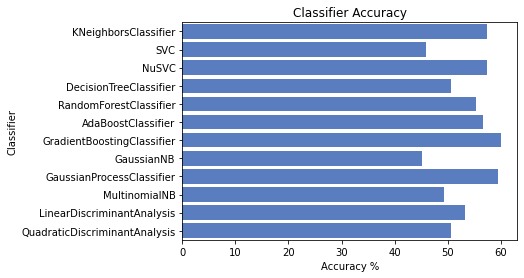

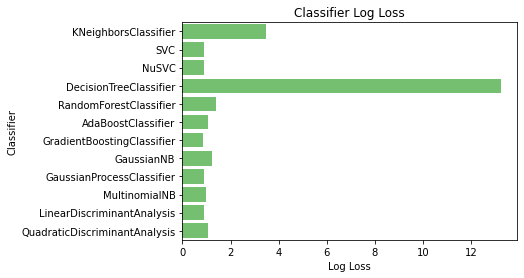

In [29]:
choose_best_clf(Xb_train, Xb_test, y_train, y_test)

data bining didn't make much difference, it only made precision/recall scores better

### Dimensionality reduction on binned data

In [30]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95)

In [31]:
d

5

Even though it says ther variance above 95% can be achieved with 6 parameters (originally there are 9),
but from the following graph we can see, that ~95% variance can be achieved with just 5 parameters, which is almost twice less than in the original data

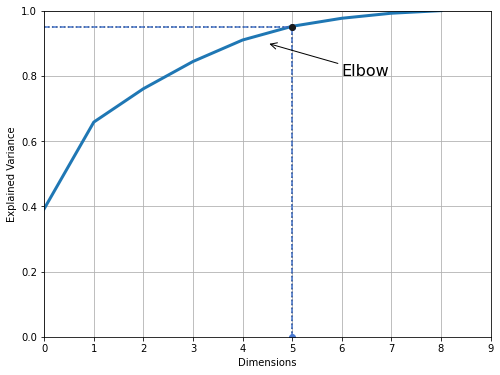

In [32]:
plt.figure(figsize=(8,6))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 9, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")


plt.plot([5, 5], [0, 0.95], marker='o', color='b', linestyle="--")
plt.plot([0, 5], [0.95, 0.95],color='b', linestyle="--")

plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(4.5, 0.9), xytext=(6, 0.8),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

In [33]:
pca = PCA(n_components=d)
pca.fit(X)
Xb_train_reduced = pca.transform(Xb_train)
Xb_test_reduced = pca.transform(Xb_test)


In [34]:
X_train_reduced

array([[-13.89285591],
       [ 11.44166845],
       [ 11.14177016],
       ...,
       [ -3.57947689],
       [  4.69884653],
       [ -1.73375754]])

KNeighborsClassifier
****Results****
Accuracy: 60.8108%
Log Loss: 4.356292506433688
SVC
****Results****
Accuracy: 54.0541%
Log Loss: 0.9193096450119019
NuSVC
****Results****
Accuracy: 58.7838%
Log Loss: 0.9040866405917648
DecisionTreeClassifier
****Results****
Accuracy: 52.0270%
Log Loss: 13.471864443724169
RandomForestClassifier
****Results****
Accuracy: 50.6757%
Log Loss: 1.2312590098931566
AdaBoostClassifier
****Results****
Accuracy: 45.9459%
Log Loss: 1.0759982812925015
GradientBoostingClassifier
****Results****
Accuracy: 55.4054%
Log Loss: 0.8745081678425896
GaussianNB
****Results****
Accuracy: 56.0811%
Log Loss: 0.9001267911185464
GaussianProcessClassifier
****Results****
Accuracy: 57.4324%
Log Loss: 0.8885046279995955

MultinomialNB cannot be trained
LinearDiscriminantAnalysis
****Results****
Accuracy: 56.0811%
Log Loss: 0.9095256916401935
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 57.4324%
Log Loss: 0.8770502588598864


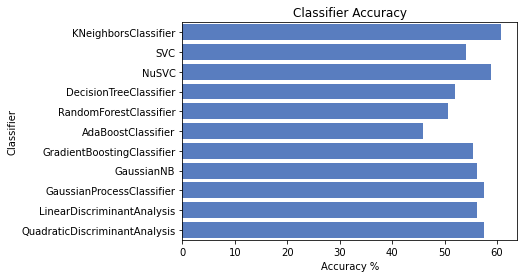

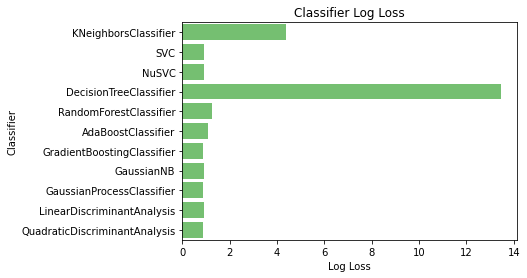

In [35]:
choose_best_clf(Xb_train_reduced, Xb_test_reduced, y_train, y_test)

## One hot encoding binned data set

In [36]:
encoded_table = pd.get_dummies(table, columns=["W_EDU", "H_EDU", "H_JOB", "SOL", "W_AGE_binned", "NUM_CHILDREN_binned"])

In [37]:
encoded_table

,W_ISLAM,W_WORKING,BAD_MEDIA,CONT_USAGE,W_EDU_1,W_EDU_2,W_EDU_3,W_EDU_4,H_EDU_1,H_EDU_2,...,W_AGE_binned_1,W_AGE_binned_2,W_AGE_binned_3,W_AGE_binned_4,NUM_CHILDREN_binned_1,NUM_CHILDREN_binned_2,NUM_CHILDREN_binned_3,NUM_CHILDREN_binned_4,NUM_CHILDREN_binned_5,NUM_CHILDREN_binned_6
0,True,False,False,1,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1,True,False,False,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,True,False,False,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,True,False,False,1,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,1
4,True,False,False,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,True,True,False,3,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
1469,True,False,False,3,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
1470,True,True,False,3,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1471,True,True,False,3,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [38]:
X = encoded_table.drop(columns=['CONT_USAGE'], inplace=False)
y = encoded_table['CONT_USAGE'].copy()

Xe_train, Xe_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

KNeighborsClassifier
****Results****
Accuracy: 52.7027%
Log Loss: 4.393715252283452
SVC
****Results****
Accuracy: 46.6216%
Log Loss: 0.9434944301477212
NuSVC
****Results****
Accuracy: 56.7568%
Log Loss: 0.9316803537241991
DecisionTreeClassifier
****Results****
Accuracy: 52.0270%
Log Loss: 12.803439998789639
RandomForestClassifier
****Results****
Accuracy: 54.0541%
Log Loss: 1.2264204896335733
AdaBoostClassifier
****Results****
Accuracy: 54.7297%
Log Loss: 1.0734083746131071
GradientBoostingClassifier
****Results****
Accuracy: 55.4054%
Log Loss: 0.8885661342510239
GaussianNB
****Results****
Accuracy: 43.9189%
Log Loss: 5.216237443542812
GaussianProcessClassifier
****Results****
Accuracy: 55.4054%
Log Loss: 0.9451027225407064
MultinomialNB
****Results****
Accuracy: 52.0270%
Log Loss: 0.9146116172733822
LinearDiscriminantAnalysis
****Results****
Accuracy: 53.3784%
Log Loss: 0.8841166938067726
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 37.1622%
Log Loss: 16.550833104008294


/Users/Alexey/miniconda3/envs/data_mining/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


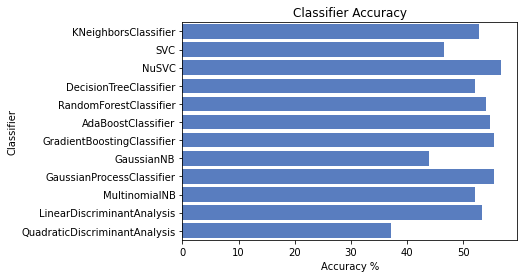

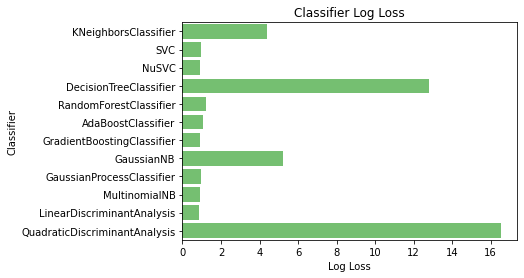

In [39]:
choose_best_clf(Xe_train, Xe_test, y_train, y_test)

### XGBoost models

In [40]:
# fit model no training data
xgb = XGBClassifier(learning_rate=0.001, 
                    n_estimators=3000,
                    gamma=5,
                    max_depth=3,
                    colsample_bytree=0.6,
                    min_child_weight=1,
                    subsample=0.6,
                    objective='multi:softmax',
                    silent=True,
                    tree='hist',
                    random_state=42
                   )
xgb.fit(Xe_train, y_train)

[22:48:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:485: 
Parameters: { silent, tree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, silent=True, subsample=0.6,
              tree='hist', tree_method='exact', validate_parameters=1,
              verbosity=None)

In [41]:
metrics(xgb, Xe_train, y_train, Xe_test, y_test)

[22:48:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:485: 
Parameters: { silent, tree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:48:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:485: 
Parameters: { silent, tree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:48:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:485: 
Parameters: { silent, tree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used 

## Neural Network

In [42]:
mlp_clf = MLPClassifier(random_state=1, max_iter=300)

#### training on original non-binned non-reduced data

In [43]:
mlp_clf.fit(X_train, y_train)

MLPClassifier(max_iter=300, random_state=1)

In [44]:
mlp_clf.predict_proba(X_test[:1])

array([[0.18376614, 0.20838602, 0.60784784]])

In [45]:
mlp_clf.score(X_test, y_test)

0.5608108108108109

#### On reduced data

In [46]:
mlp_clf = MLPClassifier(random_state=1, max_iter=500)
mlp_clf.fit(X_train_reduced, y_train)
mlp_clf.score(X_test_reduced, y_test)

0.43243243243243246

#### On binned data

In [47]:
mlp_clf = MLPClassifier(random_state=1, max_iter=700)
mlp_clf.fit(Xb_train, y_train)
mlp_clf.score(Xb_test, y_test)

0.5472972972972973

#### On binned reduced data

In [48]:
mlp_clf = MLPClassifier(random_state=1, max_iter=1500)
mlp_clf.fit(Xb_train_reduced, y_train)
mlp_clf.score(Xb_test_reduced, y_test)


0.5540540540540541

#### On hot ohe encoded data

In [49]:
mlp_clf = MLPClassifier(random_state=1, max_iter=1000)
mlp_clf.fit(Xe_train, y_train)
mlp_clf.score(Xe_test, y_test)

/Users/Alexey/miniconda3/envs/data_mining/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


0.5067567567567568